# 63X Cell Imaging
I made this pipline for all imaging data after 6_22_20. this is to perform image segmentation and store quantification data for the all images that have used 63x. Differs from the standared machine learning as it implements UNET within it. 

In [ ]:
"""Align crop images for Changhui and Jie's experiment data using the confocol
Use the gfp signal to preselect the in focus images 
"""
%matplotlib inline
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
from scipy.stats import linregress
import scipy.stats
import scipy.signal
import scipy.spatial
import pandas as pd
import numpy as np
import math, re, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
from datetime import datetime
from skimage import filters
import skimage, skimage.io, skimage.feature
from skimage.feature import register_translation
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.feature.register_translation import _upsampled_dft

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import glob
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture

from skimage.measure import label, regionprops
#so the font can be handle by illustrator
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('ggplot')


In [ ]:
def getFileList(file_dir_pattern):
    """Get the file lists organized by position, time into dictionary, z stacked images will be appended in as well
    that match the given file_dir_pattern
    Parameters:
    ============
    file_dir_pattern : pattern of the file including the directory
    """
    files = glob.glob(file_dir_pattern)
    image_files = {}
    pattern = re.compile(".*\/.*s(\d+)[t&z](\d+).*") # \d+ 0-9 digit repeats more than once, [t|z]- looks for t or z, *s any charecter that is not a whitespace
    for filename in sorted(files):
        #print filename
        match = pattern.match(filename)
        if match:
            pos = match.group(1).zfill(3) # zfill returns on the left and fills with 0
            time = int(match.group(2)) # returns the time
            image_files.setdefault(pos,{}) # .setdefault if key not in dic will make it 
            image_files[pos].setdefault(time, []) # setting the time dictionary as a list so i can append later 
            image_files[pos][time].append(filename)# double dict keys!
    return image_files

def getFileList_aggregatezstack(file_dir_pattern):
    """Get the file lists organized by position, time into dictionary, z stacked images will be appended in as well
    that match the given file_dir_pattern
    Parameters:
    ============
    file_dir_pattern : pattern of the file including the directory
    """
    files = glob.glob(file_dir_pattern)
    image_files = {}
    aggdic = {}
    pattern = re.compile(".*\/.*s(\d+)[t&z](\d+).*") # \d+ 0-9 digit repeats more than once, [t|z]- looks for t or z, *s any charecter that is not a whitespace
    for filename in files:
        #print filename
        match = pattern.match(filename)
        if match:
            pos = match.group(1).zfill(3) # zfill returns on the left and fills with 0
            time = int(match.group(2)) # returns the time
            image_files.setdefault(pos,{}) # .setdefault if key not in dic will make it 
            image_files[pos].setdefault(time, []) # setting the time dictionary as a list so i can append later 
            image_files[pos][time].append(filename)# double dict keys!
            
            # creating dictionary with aggregated values 
            first_stack = np.zeros((17, 512, 512)) # change 17 for the zstacks you hae 
            
            for i,img in enumerate(image_files[pos][time]):
                first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
                aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                aggdic[pos][time] =  np.sum(first_stack, axis = 0) # lets you add all the images together 
                
 

                
    return image_files, aggdic


def aggregatezstacks(image_files_dict):
    """uses getFileList image_files and will load the arrays and add them all together
    """
    aggdic = {}
    for pos in image_files_dict.keys():
        for time in image_files_dict[pos].keys():
            first_stack = skimage.io.imread_collection(image_files_dict[pos][time])
            first_concat = skimage.io.concatenate_images(first_stack) 
            aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
            aggdic[pos].setdefault(time, np.array()) # setting the time dictionary as a list so i can append later 
            aggdic[pos][time] = first_concat.sum(axis=0) # lets you add all the images together 

    return aggdic



def getsample_aggre(file_dir_pattern, position):
    """Get the file lists organized by position, time into dictionary, z stacked images will be appended in as well
    that match the given file_dir_pattern
    Parameters:
    ============
    file_dir_pattern : pattern of the file including the directory
    """
    files = glob.glob(file_dir_pattern)
    image_files = {}
    aggdic = {}
    pattern = re.compile(".*\/.*s(\d+)[t&z](\d+).*") # \d+ 0-9 digit repeats more than once, [t|z]- looks for t or z, *s any charecter that is not a whitespace
    for filename in files:
        #print filename
        match = pattern.match(filename)
        if match:
            
            pos = match.group(1).zfill(3) # zfill returns on the left and fills with 0
            if position in pos:
                time = int(match.group(2)) # returns the time
                image_files.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                image_files[pos].setdefault(time, []) # setting the time dictionary as a list so i can append later 
                image_files[pos][time].append(filename)# double dict keys!

            # creating dictionary with aggregated values 
                first_stack = np.zeros((17, 512, 512)) # change 17 for the zstacks you hae 

                for i,img in enumerate(image_files[pos][time]):
                    first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
                    aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                    aggdic[pos][time] = np.sum(first_stack, axis = 0) # lets you add all the images together 
 
 

                
    return image_files, aggdic

In [ ]:

def detectbackcell(dic,gfp_images,name, time, backsub = None, threshold =False) :
    """This functions similar to detectcell, however, it will peform a background subtraction and resizing of 40X40
    the purpose is to compare the cells plotted. Here the zstacks are aggregated and then follow a background subtraction
    next we turn all negatives to 0 and normalize from 0-1, the last part will involve a reshaping of 40X40 
    gfp_images = dictionary file that has all the images as pos and time
    Dic - this is the fdic that is made and has the info and BACKGROUND file 
    time is the time point you want 
    backsub = None, zstack - both remove median background
        None- removes the median background after aggregating the pictures
        'zstack' - removes the median background of each zstack and then aggregates them together 
    Threshold- will remove some of the background noise by applyinga  small thresh above the mean and turning values to 0
    example: detectbackcell( f11_8_19 ,gfp_images_11_8_19, 'pos_001_cell_1', 5)  
    detectbackcell( f11_8_19 ,gfp_images_11_8_19, 'pos_001_cell_1', 5, backsub = 'zstack', threshold = True)"""
    pos = name.split('_')[1]

     
    if backsub is None:
        background = dic['backmediandfgfp'].loc[time, pos]
        gfpic = quickaggre(pos, time , gfp_images)[pos][time ] - background # remove background 
        gfpic[gfpic<0] = 0 # normalize negatives by -1 
        
        
    if backsub == 'zstack':
        first_stack = np.zeros((17, 512, 512))  
        for zstacknumberori, z in enumerate(sorted(gfp_images[pos][time])):  # moved zstack under so I can do a better visualization
            zstacknumber = zstacknumberori +1
            img =skimage.io.imread(z,plugin='pil')  # reading in one z stack image at a time
            # assigning pic an img 
            background = dic['backmedianlszstackgfp'].loc[time].loc[zstacknumber, name]
            pic = img.copy() -background #  remove median background from the image of the designated zstack 
            pic[pic<0] = 0 # turning negatives after background to 0 
            first_stack[zstacknumberori,:,:] = pic
        gfpic  = np.sum(first_stack, axis = 0)
    
     
    
 

    infodf = dic['infodf']

    infodf1 = infodf.set_index('position')# using the info file containg the mothers mask 
    cols = infodf1.loc[infodf1.index.str.startswith(('pos_'+str(pos), pos))].index.unique().values # get all or one of the column names
    infodf1 = infodf1.reset_index()
    infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 
    infodf2 = infodf1.get_group((cols[0], time)) # every cell of the same position should have the same shift
    shift = infodf2['shift'].values[0]

    # shifting image to match the masks
    gfpic = np.roll(gfpic, int(shift[0]), axis = 0)
    gfpic = np.roll(gfpic, int(shift[1]), axis = 1)
 

    # generate the masks 
    col = name
    df = np.zeros((512,512)) # empty image
    infodf2 = infodf1.get_group((col, time))
    poly = infodf2['coords'].iloc[0]
    df[poly[:, 0], poly[:, 1]] = 1

    # y coordinate to zoom in the picture 
    ymin = pd.DataFrame(infodf2['coords'].iloc[0])[0].min()
    ymin1 = pd.DataFrame(infodf2['coords'].iloc[0])[0].max()
    # x coordinate to zoom in the picture 
    xmin = pd.DataFrame(infodf2['coords'].iloc[0])[1].min()
    xmin1 = pd.DataFrame(infodf2['coords'].iloc[0])[1].max()
 
    # changing to 40X40 and cropping image 
    gfppicture = cv2.resize(gfpic[ymin:ymin1, xmin:xmin1], (40, 40)) # gfp cropping Mother cell and resizing to 40X40
    mask =  cv2.resize(df[ymin:ymin1, xmin:xmin1], (40, 40))
    
    gfppicture = ((gfppicture - np.min(gfppicture))/( np.max(gfppicture) -np.min(gfppicture))) *1 # normalize to 0-1
    if threshold is True:
        thresh = np.mean(gfppicture) +(np.std(gfppicture)*.2)
        maskgfp = gfppicture >= thresh
        gfppicture[~maskgfp] = 0 # just turn everything else to 0 but leave the high intesnity values the same 

    
    contours = find_contours(mask, .5) # finds the corresponding peaks and draws it on the picture
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='r')

    plt.imshow(gfppicture)
    plt.title(str(name)+ '_time_'+str(time))
    plt.show()
    
    
def quickaggre(poslist, timelist, dic_images, listype = None, gaus = None):
    """To sum the zstacks of a position or time, takes in multiple times and positions OR a singular time or position
    dic_images- are bf_images, rfp_images or gfp_images. made using Jiashuns getfilelist!
    listype MUST say True or False.
        True = means poslist and timelist must be written as list form: expample ['001', '002'] and [1,217,216] 
            notice that position is written as STRING and timelist is written as INT must be kept!
        False = means poslist and timelist are SINGULAR as such '001' and 217  
            again position is STRING timelist is int
    gaus if True will peform a gausian blur, this is used on GFP! to help remove background noise 
     example to call out one set : quickaggre('006', 100 , gfp_images, False, True)['006'][100 ] """
    aggdic ={}
    if listype is True:# for multiple times and positions 
        for time in timelist:
            for pos in poslist:
                first_stack = np.zeros((len(dic_images[pos][time]), 512, 512)) 
                for i,img in enumerate(dic_images[pos][time]):
                    first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
                    aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                    if gaus is True:
                        stack = np.sum(first_stack, axis = 0)
                        aggdic[pos][time] = ndimage.gaussian_filter(stack, sigma = 1.5)
                    else:
                        aggdic[pos][time] = np.sum(first_stack, axis = 0) # lets you add all the images together 

    elif listype is None or listype is False: # for just one of the values position or time 
        first_stack = np.zeros((len(dic_images[poslist][timelist]), 512, 512)) 
        for i,img in enumerate(dic_images[poslist][timelist]):
            first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
            aggdic.setdefault(poslist,{}) # .setdefault if key not in dic will make it 
            if gaus is True:
                stack = np.sum(first_stack, axis = 0)
                aggdic[poslist][timelist] = ndimage.gaussian_filter(stack, sigma = 1.5)
            else:
                aggdic[poslist][timelist] = np.sum(first_stack, axis = 0) # lets you add all the images together 
    
        
    return aggdic


# for Netbf images path
    # this gives you the file path for each netbf that is made in refence to the position and time 
def netbfimages(filepath):
    """using the filpath given it will out put a dictionary that has the position and time in refence to the filepath"""
    dic = {}
    for filename in glob.glob(filepath ):
        file = filename.split('/')[-1] 
        pos = str(0)+file.split('_')[0]
        time = int(file.split('_')[1].replace('.npz', '')) # turning the string to a time 
        dic.setdefault(pos, {})
        dic[pos][time] = filename 

    return dic


# to load in individual netbfs
def quicknetbfagg(posref,timeref, netbf_images):
    """purpuse is to read in a netbf file individually. will be useful if you want to read just one
    posref- must be string 
    timeref - must be interger 
    netbf_images- is the dictionary that contains the file path names
    example = quicknetbfagg('001',1, netbf_images)['001'][1]  """
    
    netdic = {}
    for filename in glob.glob(netbf_images[posref][timeref]):
        file = filename.split('/')[-1] 
        pos = str(0)+file.split('_')[0]
        time = int(file.split('_')[1].replace('.npz', '')) # turning the string to a time 
        if (pos == posref) & (time == timeref):
            data =  np.load(str(filename))
            data = data['pixels']
            first_stack = np.zeros((data.shape[0], 512, 512)) # making file for zstack 
            for i in range(0,data.shape[0],1):
                first_stack[i, :, :] = data[i, :,:,1]
                netdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                    # normalizing the zstack images
                netdic[pos][time] = np.sum(first_stack, axis = 0) 
 
    return netdic

In [ ]:
# Change the following dates to make a folder and label the file name
date = '11_15_21' #'11_14_19', 10_16_19
#for zstack
datez = '63x_11_15_21' #'63x_8_3_20'
datez1 = '11_15_21'
outfilename = '/home/michael/Hao_li/Yeast_aging/Results_images/' + str(date)+'_results/'


In [ ]:
# making a directory 
import os

# define the name of the directory to be created
path = outfilename#os.getcwd()  
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

In [ ]:
import time
start = time.time()

# getting list path of the images  and making a dictionary to hold the file names
 
bf_images =  getFileList ('/microscope/michael/63x_' + str(date) +'/*c1_ORG.tif')
rfp_images  =  getFileList ('/microscope/michael/63x_' + str(date) +'/*c3_ORG.tif')
gfp_images  =  getFileList ('/microscope/michael/63x_' + str(date) +'/*c2_ORG.tif')
 

end = time.time()
print((end-start)/ 60)

0.23064008156458538


In [ ]:
## checking dytpe if it is uint8 or 16 
# also shows how we can read one image
    # use 16
pos = '009'
skimage.io.imread(bf_images[pos][1][0],plugin='pil')

array([[8219, 8636, 8754, ..., 9084, 8917, 8531],
       [8349, 8607, 8593, ..., 8031, 7798, 8040],
       [8471, 8639, 8601, ..., 7706, 7726, 7585],
       ...,
       [7154, 7403, 7507, ..., 8437, 8499, 8182],
       [7225, 7320, 7449, ..., 8188, 8204, 8178],
       [7059, 7330, 7458, ..., 8215, 8219, 7985]], dtype=uint16)

#### Filtering GFP and increasing resolution
Problem we are finding is that GFP has quite a lot of background noise. To reduce the background I prose to use ndimage.gaussian_filter(). Below I have pasted image resolutions that show before the gaussian filter and after. Note this is only applied to GFP not RFP. 

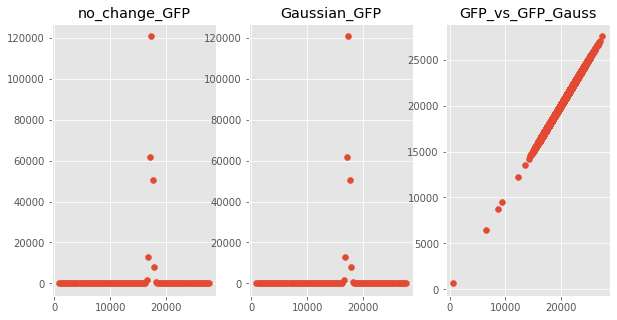

In [ ]:
### displaying differences
## Gaussian blur can be useful for other purposes. 
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (10,5))

time = 7
hist, bins = np.histogram(quickaggre(pos, time, gfp_images)[pos][time].ravel(), 100)
ax1.set_title('no_change_GFP')
ax1.scatter(bins[1:], hist)

hist, bins = np.histogram(quickaggre(pos, time, gfp_images)[pos][time].ravel(), 100)
ax2.set_title('Gaussian_GFP')
ax2.scatter(bins[1:], hist)

ax3.set_title('GFP_vs_GFP_Gauss')
ax3.scatter(quickaggre(pos, time, gfp_images)[pos][time].ravel(), quickaggre(pos, time, gfp_images)[pos][time].ravel())

In [ ]:
# making a dataframe that has position and time
l = list()
failpos = list()
for pos in bf_images.keys(): # all positions should be the same so can use bf_images or rfp_images
    for time in bf_images[pos].keys(): # just getting the same keys of time
        l.append([pos,time])
pos_time_df = pd.DataFrame(l)
pos_time_df.columns = ['pos', 'time'] # dataframe that will have position and time for each variable 
pos_time_df = pos_time_df.sort_values(['pos', 'time'], ascending=[True, True]) # sort by position and time


In [ ]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def gausmix(df,mask):
    """This is to calculate the GFP max using Gaussian mixture model,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """
    
    X =   df[mask].reshape(df[mask].shape[0],1) # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.GaussianMixture(n_components=2).fit(X) 
    maxgmm = np.max(gmm.means_)
    mingmm = np.min(gmm.means_)
    return maxgmm, mingmm  # returns the mixture component greatest min

In [ ]:
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

print('device used {}'.format(device))

device used cpu


In [ ]:
## UNET model
#https://theaisummer.com/unet-architectures/

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    
model = Unet(1,2) # 1 is for how many channels 2 is for how many it outputs i said 2, loading empty model

unetpath = '/home/michael/Hao_li/Yeast_aging/Pipeline_cell_Tracking/'
name = 'UNET_512_512' #'MCunet2'# loading in the model name
model.load_state_dict(torch.load(unetpath+'/{}.pth'.format(name), map_location={'cuda:0': 'cpu'})) # to load model with cpu
model.to(device) # will turn model for GPU or CPU depending on the device stated above
#model.eval()

Unet(
  (inc): InConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(

In [ ]:
'Calculating Flourescent level of GFP and RFP of each individual cell. Will also create a infofile containing cell location. This will take the position and time into account'
# making a dataframe that will be used for position and time 
import time as Time
from skimage.morphology import remove_small_objects
from skimage.measure import find_contours
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
import pylab
from skimage.segmentation import flood 
import cv2
import numpy as np



gfplist = []
gfp_sumlist = []
gfpGMmaxlist = []
gfpGMminlist = []
gfplistori = []
gfp_sumlistori = []
gfpGMmaxlistori = []
gfpGMminlistori = []
rfplist = []
rfpsumlist = []
rfpGMmaxlist = []
rfpGMminlist = []
failpos = []
areamasklist = []
proteinarealist = []
failrfp =[]
infolist = []

transform = transforms.ToTensor() # for transformation
for pos in sorted(rfp_images.keys()):
    # creating unique labels
    referenceimg = None
    bfimage1 = quickaggre(pos, 1 , bf_images, False)[pos][1] # read all zstacks of brightfield and merge them together 
    bfimage = (bfimage1 - np.min(bfimage1))/(np.max(bfimage1)- np.min(bfimage1))# normalize merged zstacks to 0-1
    bftensor = transform(bfimage.astype(np.float32)) # turn into tensor format 
    with torch.no_grad(): # will speed it up
        predict = model(bftensor.to(device).view(-1,1, 512,512) ).to('cpu').detach().numpy() # turn back to numpy array

    pred = predict[0,1,:,:].reshape(bfimage1.shape) ## resize the image back to 512X512 from [1,1,512,512]
    thresh =   pred.mean() + (4.2* (pred).std()) # threshold determined by observing images
    mask = pred >= thresh # creating mask outline by peforming a threshold
    mask = remove_small_objects(mask, min_size=100) # removing super small cells or junk since they tend to die 
    mask =  ndi.binary_fill_holes(ndi.binary_closing(mask))
    maskori = mask #ndi.binary_dilation(ndi.gaussian_filter(mask, sigma = 1), iterations=1)

    reflabel = skimage.morphology.label(maskori) # labeling the mask
 
    for mother in np.unique(reflabel): # all mother cells found are based on RFP first time point
        if mother == 0: # is the background so we get rid of it
            continue
 
        prev_roi = mother
        prev_mask = None
        referenceimg = None
        prev_area = None
        mask = maskori # we need to blank the mask back to the original so that every cell is referenced back to the original mask. can't do later as it backfires!
        #maskquant= None # blanking for future
        for time in sorted( rfp_images[pos]):

            if referenceimg is None: # making all images to align to the reference image of 1
                referenceimg = 'filled'#quickaggre(pos, 1 , rfp_images, False)[pos][1] #rfp_aggre[pos][1].copy()
                referenceimgbfp = quickaggre(pos, 1 , bf_images, False)[pos][1]  #using the first image as a reference point to help with alignment
                continue 

            # shifting and aligning the next images
                     # Shifting GFP alignment 
            unalignbf = quickaggre(pos, time , bf_images, False)[pos][time]  
            shift, error, diffphase = register_translation(referenceimgbfp, unalignbf, 1000)# using original bf_aggre to calculate shift
            alginimgbf = np.roll(unalignbf, int(shift[0]), axis = 0)# switched out unaliginbf 
            alginimgBF = np.roll(alginimgbf, int(shift[1]), axis = 1) # aligining image back to reference point
            
            # shifting RFP
            unalignrfp = quickaggre(pos, time , rfp_images, False)[pos][time] 
            alginimgrfp = np.roll(unalignrfp, int(shift[0]), axis = 0)
            alginimgRFP =  np.roll(alginimgrfp, int(shift[1]), axis = 1)# aligining image back to reference point

            # Shifting GFP alignment 
            unaligngfp = quickaggre(pos, time, gfp_images, False, True)[pos][time] 
            alginimggfp = np.roll(unaligngfp, int(shift[0]), axis = 0)
            alginimgGFP = np.roll(alginimggfp, int(shift[1]), axis = 1)# aligining image back to reference point
            
             # Shifting original GFP alignment 
            unaligngfpori = quickaggre(pos, time, gfp_images, False)[pos][time] 
            alginimggfpori = np.roll(unaligngfpori, int(shift[0]), axis = 0)
            alginimgGFPori = np.roll(alginimggfpori, int(shift[1]), axis = 1)# aligining image back to reference point
                 
            
            if prev_mask is None: # First frame WILL be used only!
                prev_mask = mask # setting up the first original mask to restart each time
                check = None
 
                #continue
            
            else:
                bfimage1 = alginimgBF.copy()
                bfimage = (bfimage1 - np.min(bfimage1))/(np.max(bfimage1)-np.min(bfimage1))# normalize merged zstacks to 0-1
                bftensor = transform(bfimage.astype(np.float32)) # must be np.float32 or else unet WILL not accept it
                with torch.no_grad(): # will speed it up
                    predict = model(bftensor.to(device).view(-1,1, 512,512)).to('cpu').detach().numpy()
              
                pred = predict[0,1,:,:].reshape(512,512)
                thresh = pred.mean()  + (4.5* (pred).std())
                mask = pred >= thresh
                mask = remove_small_objects(mask, min_size=100)
                mask =  ndi.binary_fill_holes(ndi.binary_closing(mask))

            # here we are setting up the previous mask and the current mask 
            label1 = skimage.morphology.label(prev_mask) # NDI label
            label2 = skimage.morphology.label(mask)

            roi_mask1 = label1 == prev_roi
            best_roi = -1
            best_sum = 0
            for i in np.unique(label2):
                if i == 0:  # is the background so we get rid of it
                    continue
                if len(regionprops(label2))>0 : # to remove any frame that has no cells 
                    roi_mask2 = label2 == i # selecting the mask of the previous frame 
                    roi_sum = np.sum(roi_mask1*roi_mask2) # multiplying the masks to shift it 
                    if roi_sum > best_sum:
                        best_sum = roi_sum
                        best_roi = i

                        #prev_roi = best_roi
            if (best_roi > 0):
                #maskquant= label2 == best_roi
                    # making the mask
                try:
                    maskquant = label2 == best_roi # the mask used to pick the cell we want 
                    maskquant2 = maskquant #scipy.ndimage.morphology.binary_dilation(maskquant, iterations=1)# change if you want to get more of the cell. initially used to get that
                    area = np.sum(maskquant)
 
                    if check is None:
                        prev_area = np.sum(maskquant2)  
                        precircle= None
                    check = regionprops(label(maskquant))
                    for circle in check:
                        if precircle is None:
                            precircle = circle 

                        if (area> (1.2 *prev_area) ) or (area< (.85 *prev_area) ) or (circle.eccentricity < (.4*precircle.eccentricity)): # using area and eccentricty to remove bad mothers
                            maskquant = label1 == prev_roi # switching out to the previous mask which is label1 with the previous roi
                            best_roi = prev_roi
                            mask = prev_mask
                            circle = precircle

                            if np.sum(label2 == best_roi) <= 1:
                                best_roi = prev_roi
                        maskquant2 = maskquant #scipy.ndimage.morphology.binary_dilation(maskquant, iterations=2) # to get the RFP signal
                        area = np.sum(maskquant)


                  

                except:
                    pass 
            
 

            if best_roi < 0:
                failpos.append([str(pos) + '_cell_' +str(mother)+'time_'+str(time)])
                

           #calculating the values
            position = 'pos' + '_'+ str(pos) + '_cell_' +str(mother)
            timepoint = time
            

            rfp_pixmax = np.max(alginimgRFP[maskquant2])
            rfp_pixsum = np.sum(alginimgRFP[maskquant2])
            rfp_pixGMmax, rfp_pixGMmin =gausmix(alginimgRFP,maskquant2)# gaussian mixture function
            
            gfp_pixmax = np.max(alginimgGFP[maskquant])
            gfp_pixsum = np.sum(alginimgGFP[maskquant])
            gfp_pixGMmax, gfp_pixGMmin = gausmix(alginimgGFP,maskquant)# gaussian mixture function
            
            gfp_pixmaxori = np.max(alginimgGFPori[maskquant])
            gfp_pixsumori = np.sum(alginimgGFPori[maskquant])
            gfp_pixGMmaxori, gfp_pixGMminori = gausmix(alginimgGFPori,maskquant)

            gfplist.append([position,timepoint,gfp_pixmax])
            gfp_sumlist.append([position,timepoint,gfp_pixsum])
            gfpGMmaxlist.append([position,timepoint,gfp_pixGMmax])# mean max pixel after Gaus mixture model
            gfpGMminlist.append([position,timepoint,gfp_pixGMmin])
            
            gfplistori.append([position,timepoint,gfp_pixmaxori])
            gfp_sumlistori.append([position,timepoint,gfp_pixsumori])
            gfpGMmaxlistori.append([position,timepoint,gfp_pixGMmaxori])# mean max pixel after Gaus mixture model
            gfpGMminlistori.append([position,timepoint,gfp_pixGMminori])
            
            rfplist.append([position,timepoint,rfp_pixmax])# max
            rfpsumlist.append([position,timepoint,rfp_pixsum]) # sum
            rfpGMmaxlist.append([position,timepoint,rfp_pixGMmax]) # mean max pixel after Gaus mixture model
            rfpGMminlist.append([position,timepoint,rfp_pixGMmin])
                #calculating cell area and how much space a protein or organelle is occupying            
            proteinarea = alginimgGFP.copy()
            try:
                proteinarea = proteinarea> threshold_otsu(proteinarea[maskquant]) # also servers as a normalize comparing 0,1
            except:
                pass
            proteinarea  = np.sum(proteinarea[maskquant]) # pixel NOT being measured it is sum of TRUEs
            
            proteinarealist.append([position,timepoint,proteinarea])
            areamasklist.append([position,timepoint,area]) # for cell
            
            infolist.append([position, timepoint, area, shift,circle.eccentricity, circle.centroid[0],circle.centroid[1], circle.coords ])

            if (best_roi > 0): # best roi will be -1 if the label2 has a shitty image
                prev_roi = best_roi # to replace 
                prev_mask = mask
                prev_area = area
                check = regionprops(label(maskquant))
                precircle = circle 


            #if time > 41: break
end = Time.time()
print((end-start)/60, 'minutes to run')
    
del referenceimg, referenceimgbfp, unalignbf, unalignrfp,unaligngfp,unaligngfpori

1119.7980727513632 minutes to run


In [ ]:
# function to make a dataframe with Ease
def makedf(dflist):
    df = pd.DataFrame(dflist)
    df.columns = ['position', 'time', 'value']
    df = df.sort_values('time')
    df = df.pivot(index = 'time', columns='position')['value']
    df1 = df.sort_index()
    return df1

In [ ]:
infodf = pd.DataFrame(infolist)
infolist.append([position, timepoint, area, shift,circle.eccentricity, circle.centroid[0],circle.centroid[1], circle.coords ])

infodf.columns = ['position', 'time', 'area', 'shift', 'eccentricity', 'circle_center_x', 'circle_center_y', 'coords']
infodf = infodf.set_index('position')
infodf['date'] = bf_images[list(bf_images.keys())[0]][1][0].split('/')[-2]

In [ ]:
## MAX RFP
rfpdf = makedf(rfplist)
## SUM RFP
rfpsumdf = makedf(rfpsumlist)

## Max using Gaussian
rfpGMmaxdf =  makedf(rfpGMmaxlist)
rfpGMmindf =  makedf(rfpGMminlist)
## MAX GFP
gfpdf = makedf(gfplist)
gfpdfori = makedf(gfplistori)
## sum GFP
gfpsumdf = makedf(gfp_sumlist)
gfpsumdfori = makedf(gfp_sumlistori)

## Max  and min using Gaussian
gfpGMmaxdf =  makedf(gfpGMmaxlist)
gfpGMmaxdfori =  makedf(gfpGMmaxlistori)
gfpGMmindfori= makedf(gfpGMminlistori)
gfpGMmindf =  makedf(gfpGMminlist)

## Area of cell
areamaskdf = makedf(areamasklist) #measures TRUE and False not PIXEL values !

## Area of protein occupying cell or organelle 
proteinareadf = makedf(proteinarealist) #measures TRUE and False not PIXEL values !

#calculating radius and Volume assuming it is sphere like 
radiusdf = np.sqrt((areamaskdf/(4*np.pi))) # pretenidng it is a sphere so we can get radius 
volumedf = (4/3)*(np.pi)*(radiusdf*radiusdf*radiusdf)


# normalizing for AREA
gfpmaxnorm = gfpdf/areamaskdf
gfpsumnorm = gfpsumdf/areamaskdf
gfpmaxnormori = gfpdfori/areamaskdf
gfpsumnormori = gfpsumdfori/areamaskdf

rfpmaxnorm = rfpdf/areamaskdf
rfpsumnorm = rfpsumdf/areamaskdf
   
# normalizing for volume 
gfpmaxvoln = gfpdf/volumedf
gfpsumvoln = gfpsumdf/volumedf
gfpmaxvolnori = gfpdfori/volumedf
gfpsumvolnori = gfpsumdfori/volumedf

rfpmaxvolnm = rfpdf/volumedf
rfpsumvolnrm = rfpsumdf/volumedf


# collecting all the failed frames and its positions 
    # outputs two columns position and time, for the masks that failed 
l = list()
for i in failpos:
    for v in list(i):
        possplit = v.split('time_')[0]
        timesplit = v.split('time_')[1]
        l.append([possplit,timesplit])

failposdf = pd.DataFrame(l)
failposdf.columns = ['position', 'time']

015 2


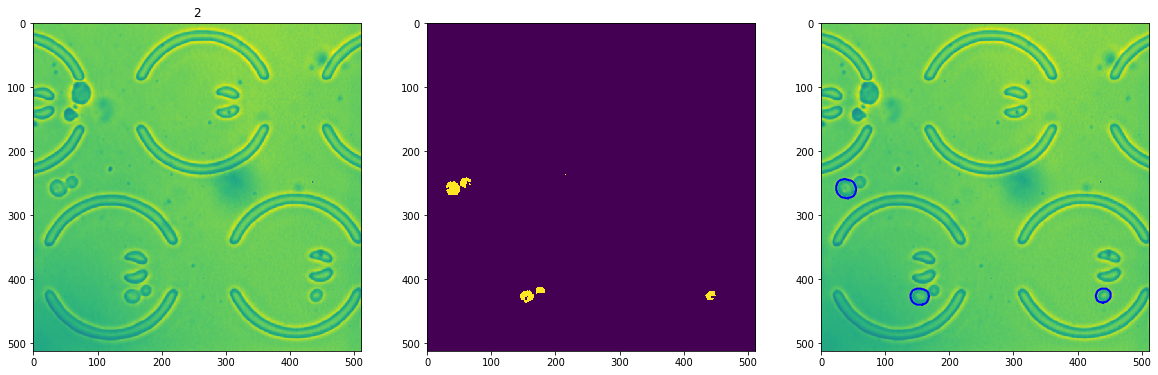

015 3


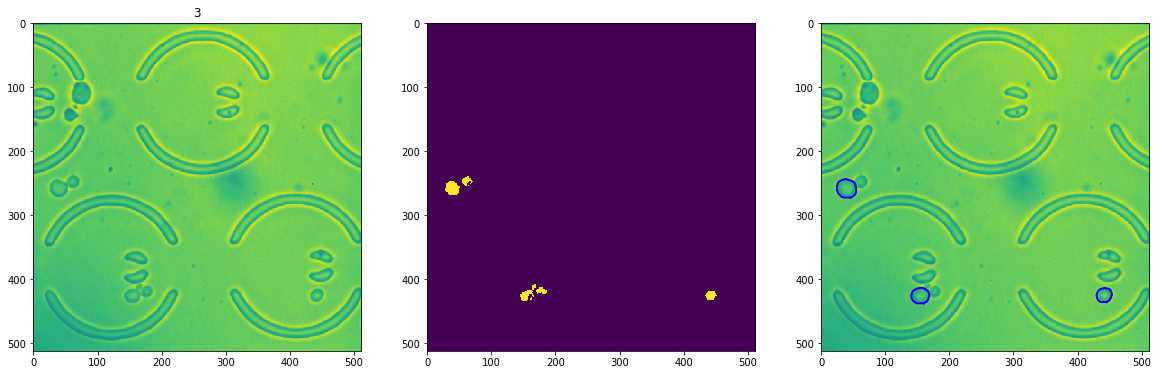

015 4


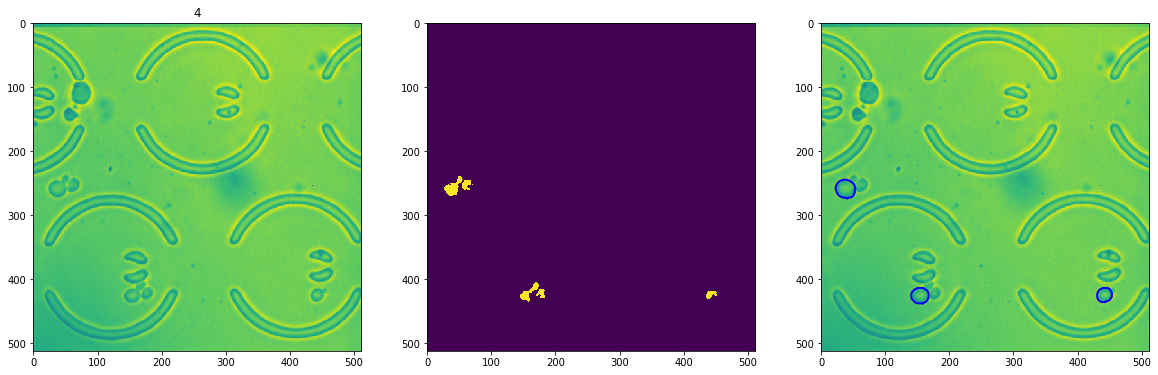

015 5


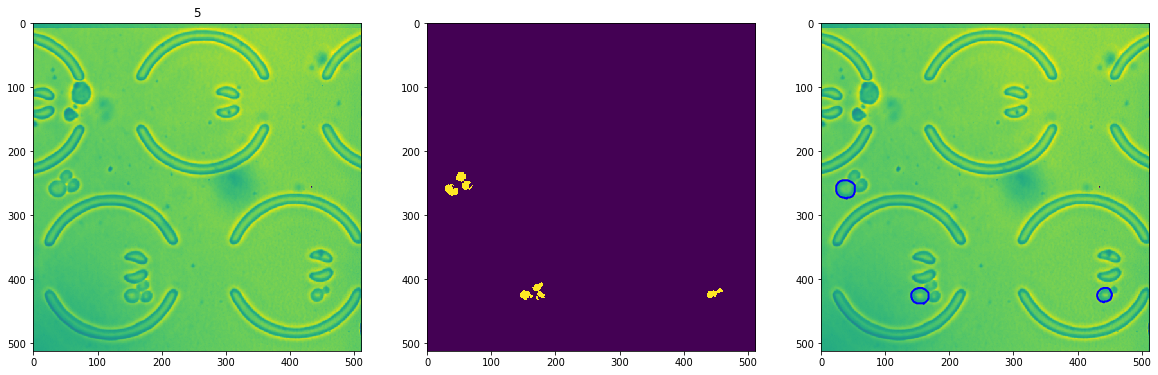

015 6


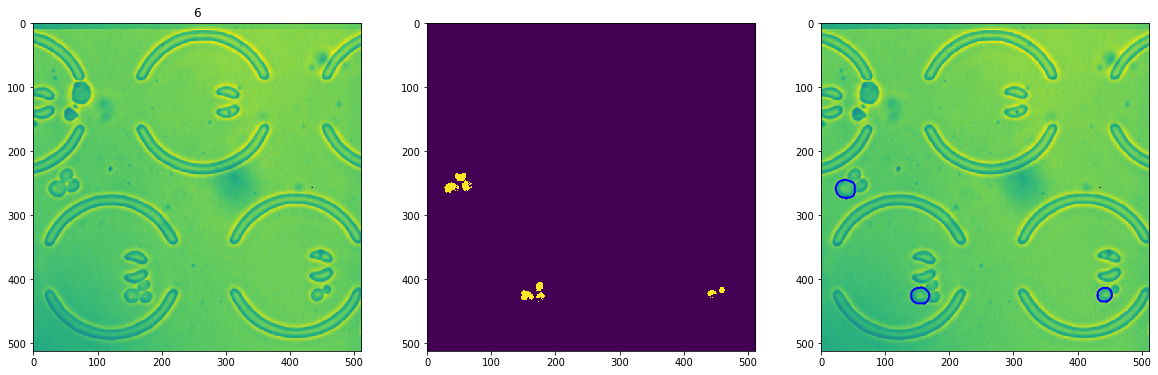

015 7


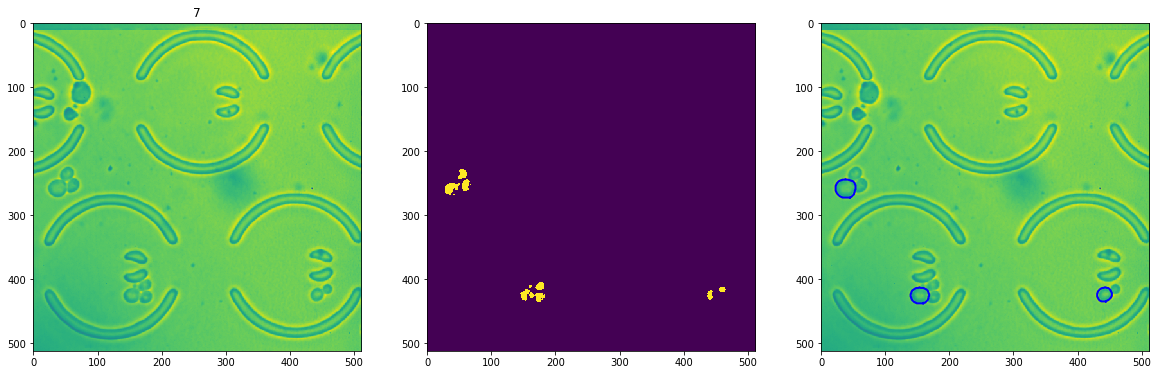

015 8


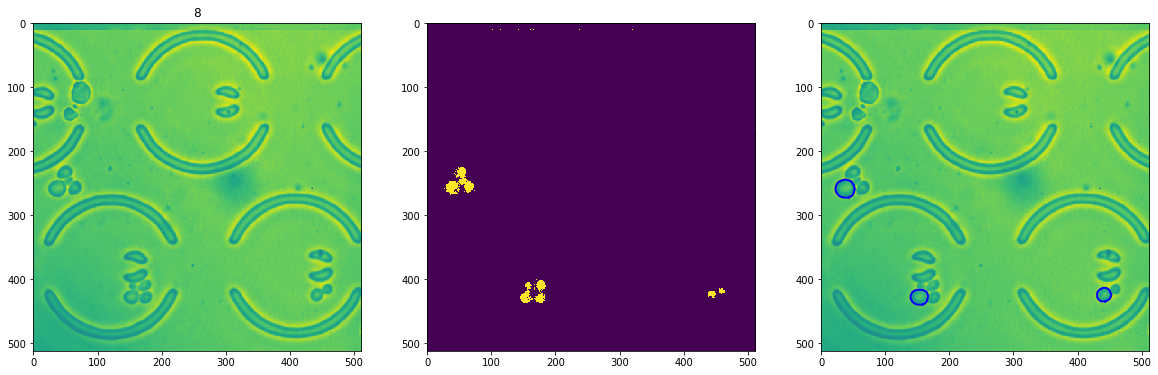

015 9


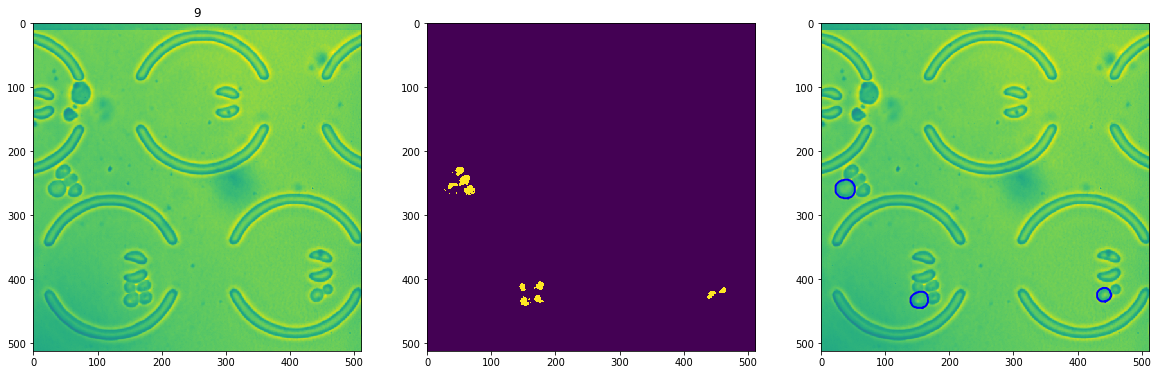

015 10


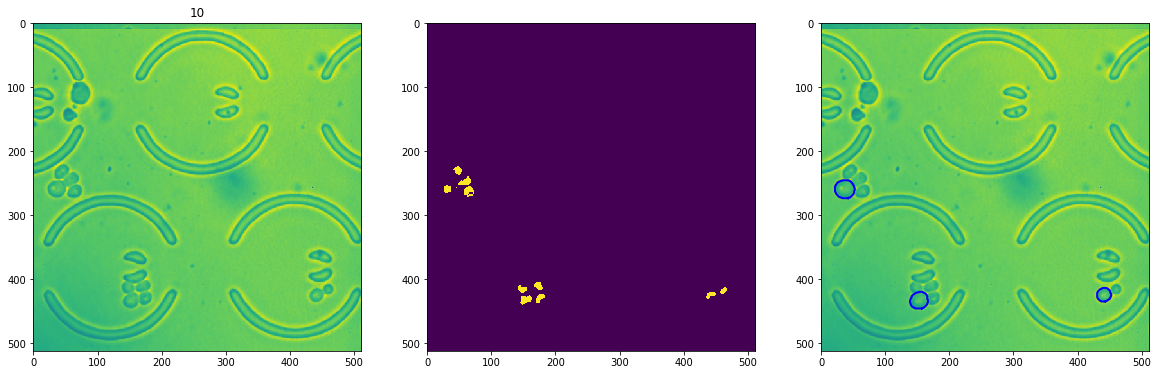

015 11


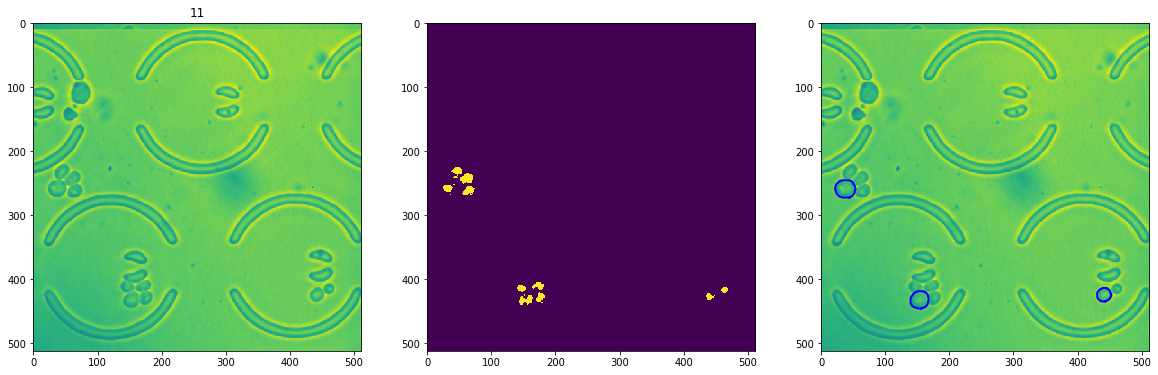

015 12


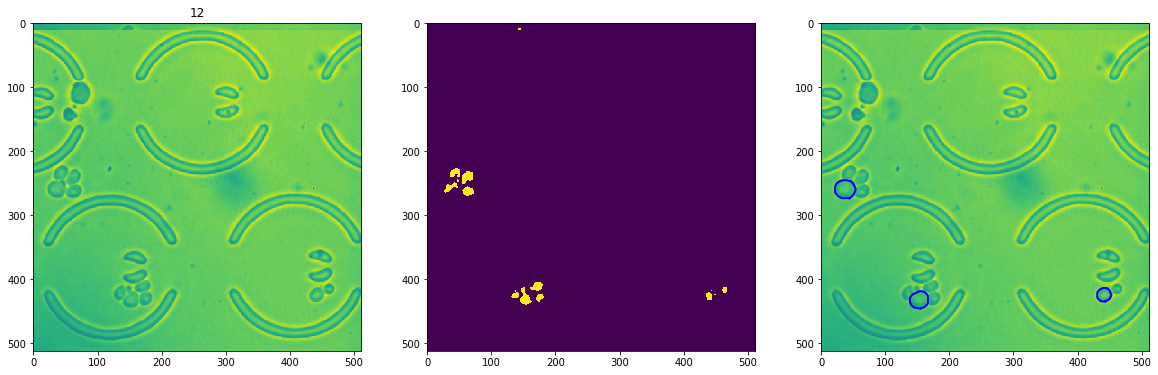

015 13


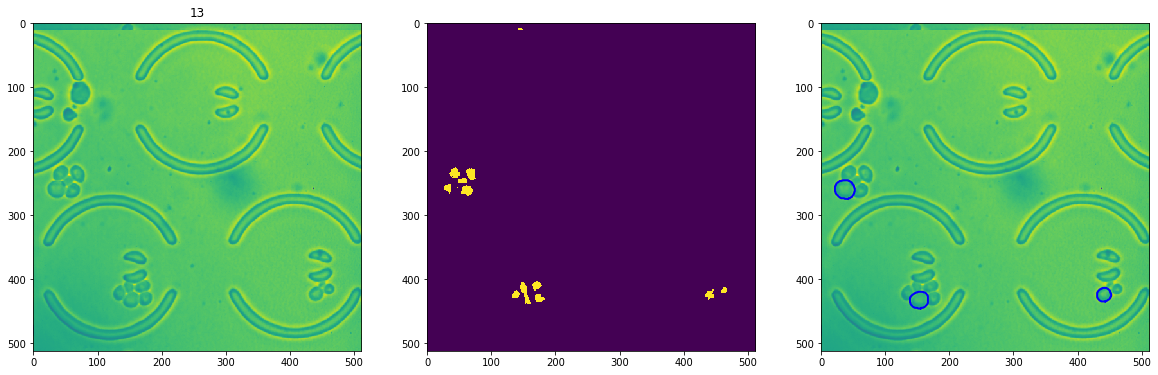

015 14


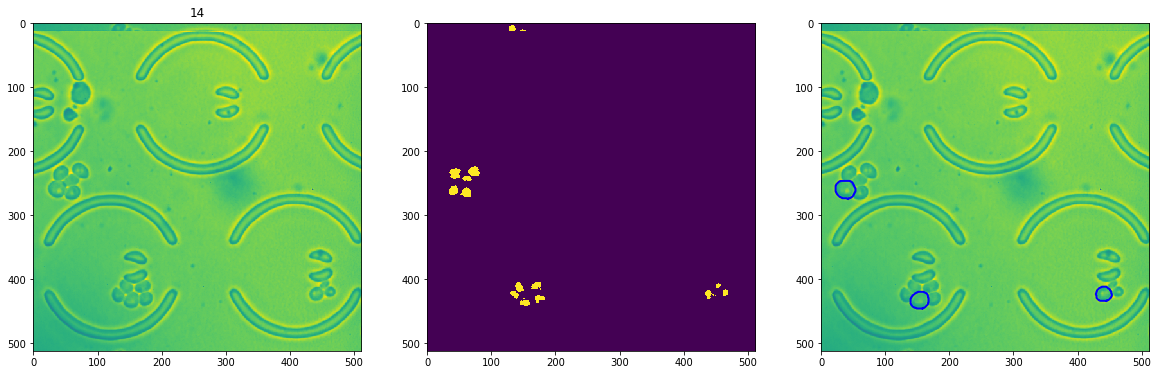

015 15


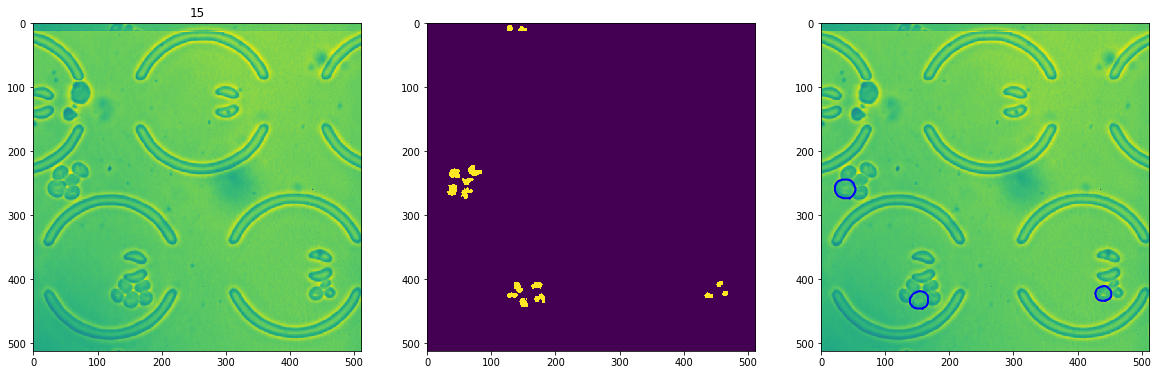

015 16


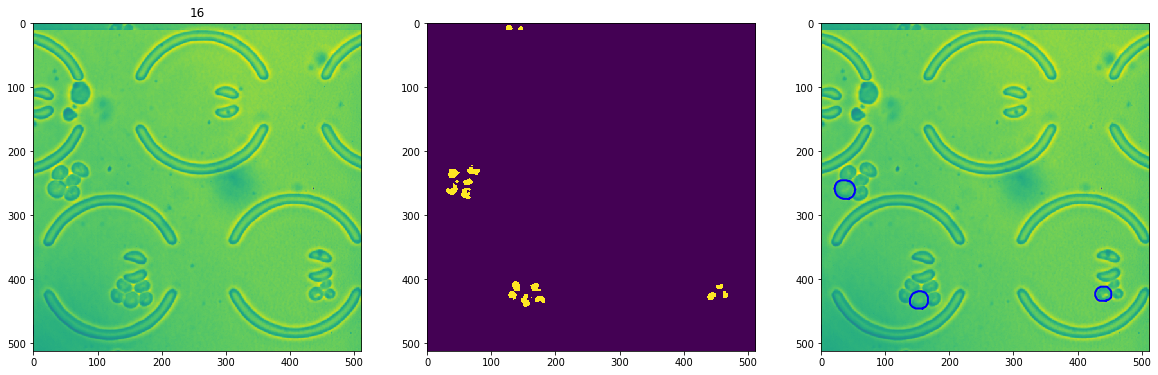

KeyboardInterrupt: 

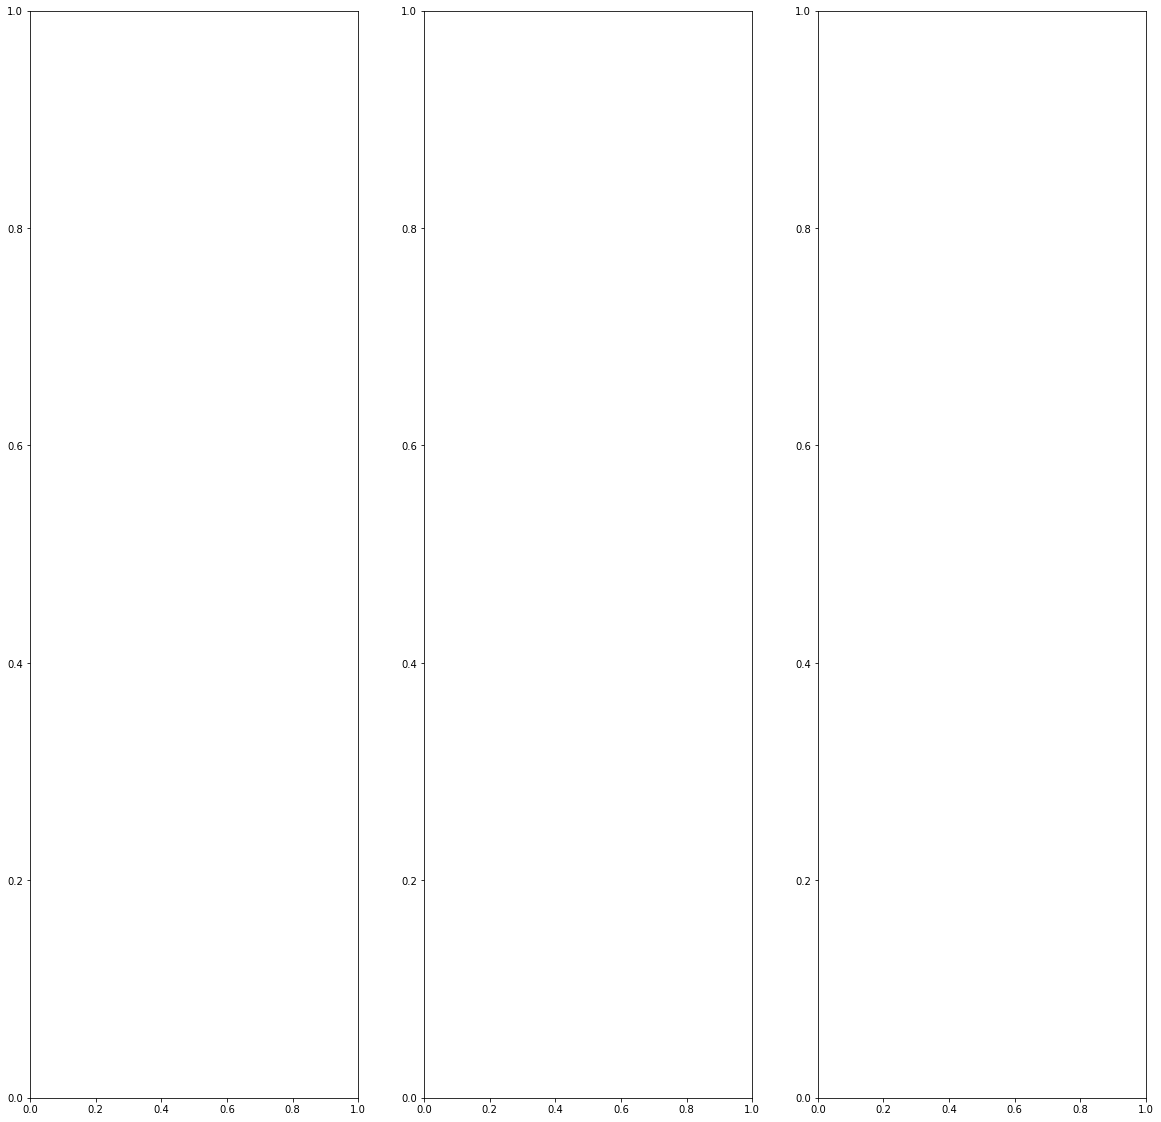

In [ ]:
pos = '015'
'observing cell-tracking notice how only the mother cell is picked while daughter cells found in the midle channel are being ignored'
l = []
infodf1 = infodf.reset_index()
infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 

for cell in infodf.reset_index()['position']:
    if cell.startswith('pos_'+pos +'_'):
        l.append(cell)
cells = set(l)
for time in infodf['time'].unique():
    df = np.zeros((512,512))
    for name in cells:

        infodf2 = infodf1.get_group((name, time))

        poly = infodf2['coords'].iloc[0]

        df[poly[:, 0], poly[:, 1]] = 1
    f, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (20,20))
    shift = infodf2['shift'].values[0]
    bf = quickaggre(pos, time , bf_images, False)[pos][time] 
    rfp = quickaggre(pos, time , rfp_images, False)[pos][time] 
    bf= np.roll(bf, int(shift[0]), axis = 0)
    bf = np.roll(bf, int(shift[1]), axis = 1)
    rfp = np.roll(rfp, int(shift[0]), axis = 0)
    rfp = np.roll(rfp, int(shift[1]), axis = 1)
    ax1.imshow(bf)
    thresh = np.mean(rfp) +np.std(rfp)*3
    ax2.imshow(rfp > thresh)
    ax3.imshow(bf)
    ax1.set_title(time)
    contours = find_contours(df, .5) # finds the corresponding peaks and draws it on the picture
    for contour in contours:
        ax3.plot(contour[:, 1], contour[:, 0], linewidth=2, color='b')

# Background Calculations
Using brightfield to determine where the wells and cells are. Afterwards we are removing the areas of occupancy to calculate the background of each channel. This will later be used to subtract it out from the raw data and to store for future use. Keep in mind this background subtraction is for the merged zstacks! Individual background per each zstack will be caculated later.

In [ ]:
import time as Time
# using netbf to stat where we subtract 
backmedianls = []
backmeanls = []  
backmedianls_RFP = []
backmeanls_RFP = []  

start = Time.time()
for pos in bf_images.keys():
    for time in bf_images[pos].keys():
        # loading files 
        bf = quickaggre(pos, time, bf_images)[pos][time]
        #Providing Threshold to remove real signal such as cells and the wells 
        bf = ((bf - np.min(bf))/(np.max(bf)- np.min(bf)))*255 # normalize the BF
        mean = np.mean(bf)
        sd = np.std(bf) *1.2
        thre = mean - sd
        sob = sobel(bf > thre)
 
        
        bm = scipy.ndimage.morphology.binary_dilation(sob, iterations=15) #dilate in case sobel missed anything
        
        gfpbackground1 = quickaggre(pos, time, gfp_images)[pos][time]
        gfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
        gfpbackground = gfpbackground1[gfpbackground1 != 0]
        
        #rfp subtraction 
        rfpbackground1= quickaggre(pos, time, rfp_images)[pos][time]
        rfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
        rfpbackground = rfpbackground1[rfpbackground1 != 0]
        
        # for GFP background subraction dataframe
        backmedianls.append([time,pos, np.median(gfpbackground)])
        backmeanls.append([time,pos, np.mean(gfpbackground)])
        
        # for RFP background subtraction 
        backmedianls_RFP.append([time,pos, np.median(rfpbackground)])
        backmeanls_RFP.append([time,pos, np.mean(rfpbackground)])        
        
        del bf, gfpbackground, rfpbackground

end = Time.time()
print((end-start)/60)

59.574519181251524


In [ ]:
# turning list of backgroound into a dataframe
# for GFP 
df = pd.DataFrame(backmeanls) 
df.columns = ['time', 'position', 'values']
df = df.pivot(index = 'time', columns = 'position')['values']
backmeandf = df.loc[3:,:]

df = pd.DataFrame(backmedianls) 
df.columns = ['time', 'position', 'values']
df = df.pivot(index = 'time', columns = 'position')['values']
backmediandf =  df.loc[3:,:]

# for RFP 
df = pd.DataFrame(backmeanls_RFP) 
df.columns = ['time', 'position', 'values']
df = df.pivot(index = 'time', columns = 'position')['values']
backmeanls_RFPdf = df.loc[3:,:]

df = pd.DataFrame(backmedianls_RFP) 
df.columns = ['time', 'position', 'values']
df = df.pivot(index = 'time', columns = 'position')['values']
backmedianls_RFPdf =  df.loc[3:,:]  

In [ ]:
# saving the background calculations for the two flourescent channels
date = bf_images[list(bf_images.keys())[0]][1][0].split('/')[-2] # Adding the date 
backmeandf.to_pickle(outfilename +str("backmeandfgfp_" +str(date)+".pkl")) 
backmediandf.to_pickle(outfilename +str("backmediandfgfp_" +str(date)+".pkl")) 

backmeanls_RFPdf.to_pickle(outfilename +str("backmeandfrfp_" +str(date)+".pkl")) 
backmedianls_RFPdf.to_pickle(outfilename +str("backmediandfrfp_" +str(date)+".pkl")) 

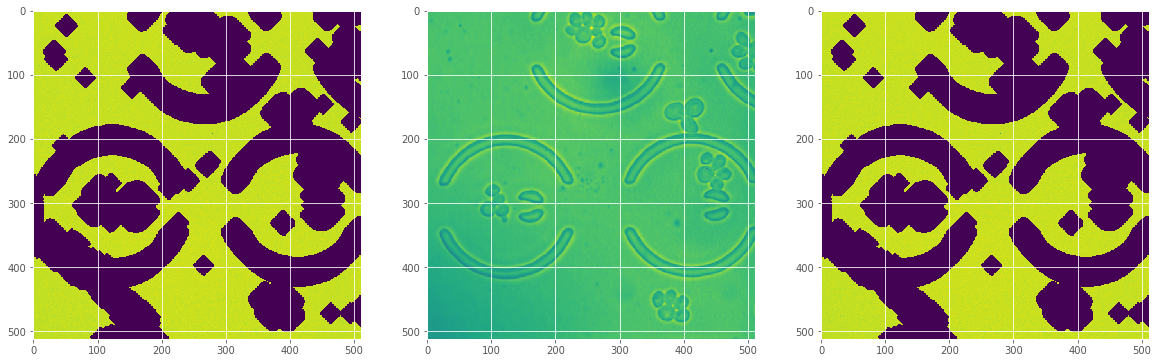

In [ ]:
# illustrating a random image taken to determine areas of occupancy. 
# green/yellow indicates the parts of the images used for background calculation
pos = '015'
time = 20
bf = quickaggre(pos, time, bf_images)[pos][time] # add all zstacks together to make one image

 
#BF
bf = ((bf - np.min(bf))/(np.max(bf)-np.min(bf)))*255 # normalize the BF


mean = np.mean(bf)
sd = np.std(bf) *1.2
thre = mean - sd
sob = sobel(bf > thre)


#netbf

 
    
bm = scipy.ndimage.morphology.binary_dilation(sob, iterations=15)#dilate in case sobel missed anything
#bm = ndimage.gaussian_filter(bm, sigma = 10)

gfpbackground1 = quickaggre(pos, time, gfp_images)[pos][time]
gfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
gfpbackground = gfpbackground1[gfpbackground1 != 0]

#rfp subtraction 
rfpbackground1= quickaggre(pos, time, rfp_images)[pos][time]
rfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
rfpbackground = rfpbackground1[rfpbackground1 != 0]

# for GFP background subraction dataframe
backmedianls.append([time,pos, np.median(gfpbackground)])
backmeanls.append([time,pos, np.mean(gfpbackground)])

# for RFP background subtraction 
backmedianls_RFP.append([time,pos, np.median(rfpbackground)])
backmeanls_RFP.append([time,pos, np.mean(rfpbackground)])  

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,20))

ax1.imshow(rfpbackground1)
ax2.imshow(bf)
ax3.imshow(bf+rfpbackground1)



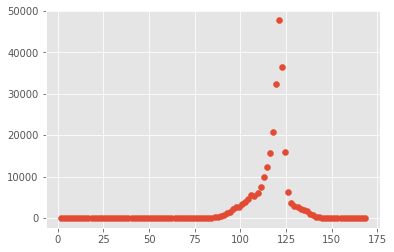

In [ ]:
# observing data distrubition
hist, bins = np.histogram(bf, 100)
plt.scatter(bins[1:], hist)

In [ ]:
def backsub(background, dataframe):
    dfmerge = pd.DataFrame(index = background.index)
    for col in background.columns:
        colcell = 'pos_' +str(col)+'_'
        collist = dataframe.columns.str.startswith(colcell)
        df1 = dataframe.loc[:,collist]
        df2 = df1.sub(background[col], axis='index')
        dfmerge = dfmerge.merge(df2, on = 'time', how = 'outer')
    return dfmerge

In [ ]:
# subtracting background from dataframes of GFPsum and GFPgmMAX
    # each position has a specifc background range so I am subtracting it
gfpsumMeanback = backsub(backmeandf, gfpsumdf)
gfpsumMedback = backsub(backmediandf, gfpsumdf)  

gfpsumMeanGMMAXback = backsub(backmeandf, gfpGMmaxdf)
gfpsumMedGMMAXback = backsub(backmediandf, gfpGMmaxdf) 

In [ ]:
# purpose to get the mean of several time points, and get the range between them
def convunorm(data,dist, add = None):
    """data is ur df that has the GFP or RFP calculations dist refers to the number range you want to calculate mean
    function will output the mean of time ranges, you can pick them by CHANGING dist,
    add is a LIST for 1 or more numbers represents if you want to put any other positions that were previously missing"""
    if dist != None:
        l = list()
        x  = data.rolling(dist).mean()  # this will basically perform a convulsion of the number dist u put, the firt will have NAS
        #min and max of your dataframe times
        mintime = np.min(data.index.values)
        maxtime = np.max(data.index.values)
        if add != None:
            if len(add) == 1:
                l.append(x.loc[add[0],:])
            else:
                for i in add: # MUST BE IN LIST FORM
                    l.append(x.loc[i,:])
        for num in range(mintime,maxtime, dist):
            l.append(x.iloc[num,:]) # pulling out the range number 
        mean_matrix = pd.concat(l, axis = 1).T.dropna()
    else:
        mean_matrix = data 
        
    return mean_matrix.sort_index() 

 
 

# Graphing and viewing Correlations
Playing with Data. Below I have inputs to make graphs to show GFP and RFP correlations as well as a accumulation of the calculated averages. Furthermore, I also have animations below 

In [ ]:
timeused = pd.Series(gfpdf.iloc[:,1].index)

In [ ]:
# calculating cell correlation to time
# leftover code not important but CHANGE strain to indicate the name of the proteins being monitored
corrdf = list()
date = bf_images[list(bf_images.keys())[0]][1][0].split('/')[-2] # Adding the date 

for col in gfpdf.columns:
    m,b, r, p, sd = linregress(gfpdf.loc[:,col], rfpdf.loc[:,col])
    m,b, r2, p, sd = linregress(gfpdf.loc[:,col], timeused)
    ma,ba, r2a, pa, sda = linregress(areamaskdf.loc[:,col], timeused)
    mag,bag, r2ag, pag, sdag = linregress(areamaskdf.loc[:,col], gfpdf.loc[:,col])
    spear, pvalue = scipy.stats.spearmanr(gfpdf.loc[:,col], timeused) # calculating spearman of GFP overtime
    
    if '001' in col or '002' in col or '003' in col or '004' in col:
        strain = 'trx2_dt_hsp104'
    if '005' in col or '006' in col or '007' in col or '009' in col or '008' in col or '010' in col or '011' in col:
        strain = 'trx2_dt_hsp104'
    if '012' in col or '013' in col or '014' in col :
        strain = 'trx2_dt_hsp104'
        
    if  '015' in col or '016' in col or '017' in col or '018' in col or '019' in col or '020' in col:
        strain = 'cox4_dt_rpn11'
    if '021' in col or '022' in col or '023' in col or '024' in col:
        strain = 'cox4_dt_rpn11'
    if '025' in col or '026' in col or '027' in col or '028' in col:
        strain = 'cox4_dt_rpn11'
    if '025' in col or '026' in col or '027' in col or '028' in col:
        strain = 'cox4_dt_rpn11'
    if '029' in col or '030' in col or '031' in col or '032' in col or '033' in col:
        strain = 'cox4_dt_rpn11'
        
    corrdf.append([date,strain, col, r, r2, spear,r2a,r2ag])
    
# turning it into a dataframe
r2timedf = pd.DataFrame(corrdf)
r2timedf.columns = ['date', 'strain', 'position', 'R2_gfp_rfp', 'R2_GFP_time', 'spear_GFP_time','R2_area_time', 'R2_area_gfpmax' ]
r2timedf['name'] = r2timedf['position'].astype(str) + '_'+r2timedf['strain'].astype(str) # adding strain name

# adding some key columns to the infodf file 
infodf = pd.merge(r2timedf, infodf, on = ['position', 'date']).drop(columns = ['R2_gfp_rfp', 'R2_GFP_time','spear_GFP_time', 'R2_area_time','R2_area_gfpmax'])
infodf['name2'] =  infodf['date']+'_'+infodf['name']

## making a dictionary that houses a list of the positions of strains
straindic = {}
for strain in r2timedf['strain'].unique():
    straindic[strain] = r2timedf.loc[r2timedf['strain'] == strain, 'position'].tolist()

/home/michael/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/michael/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [ ]:
## calculating the average Correlation for each strain
    # previously we have calculated the correlation between GFP and time for each individual cell
    # now i want to know what is the average correlation between each individual cells as well as the variation and mean
l = list()
for strain in r2timedf['strain'].unique():
    mean = np.mean(r2timedf.loc[r2timedf['strain']== strain]['R2_GFP_time'])
    meanspear = np.mean(r2timedf.loc[r2timedf['strain']== strain]['spear_GFP_time'])
    sd = np.std(r2timedf.loc[r2timedf['strain']== strain]['R2_GFP_time'])
    number = r2timedf.loc[r2timedf['strain']== strain]['R2_GFP_time'].shape[0] 

    l.append([strain, mean, meanspear, sd, number])
    
avercorrdf = pd.DataFrame(l)
avercorrdf.columns = ['strain', 'mean_R2', 'meanspearman', 'standared_deviation', 'cell_number']
    

In [ ]:
avercorrdf

strain   mean_R2  meanspearman  standared_deviation  cell_number
0  trx2_dt_hsp104 -0.344860     -0.275449             0.413721           68
1   cox4_dt_rpn11 -0.357565     -0.389059             0.453564           61

# Saving Files

In [1]:
import pickle
import bz2
 
infodf.to_pickle(outfilename +str("infodf_" +str(date)+".pkl"))
gfpGMmindf.to_pickle(outfilename +str("gfpGMmindf_" +str(date)+".pkl"))
gfpGMmindfori.to_pickle(outfilename +str("gfpGMmindfori_" +str(date)+".pkl"))
rfpGMmindf.to_pickle(outfilename +str("rfpGMmindf_" +str(date)+".pkl"))

rfpdf.to_pickle(outfilename +str("rfpdf_" +str(date)+".pkl"))
rfpsumdf.to_pickle(outfilename +str("rfpsumdf_" +str(date)+".pkl"))
rfpGMmaxdf.to_pickle(outfilename +str("rfpGMmaxdf_" +str(date)+".pkl"))
gfpdf.to_pickle(outfilename +str("gfpdf_" +str(date)+".pkl"))
gfpdfori.to_pickle(outfilename +str("gfpdfori_" +str(date)+".pkl"))
gfpsumdf.to_pickle(outfilename +str("gfpsumdf_" +str(date)+".pkl"))
gfpsumdfori.to_pickle(outfilename +str("gfpsumdfori_" +str(date)+".pkl"))
gfpGMmaxdf.to_pickle(outfilename +str("gfpGMmaxdf_" +str(date)+".pkl"))
gfpGMmaxdfori.to_pickle(outfilename +str("gfpGMmaxdfori_" +str(date)+".pkl"))
proteinareadf.to_pickle(outfilename +str("proteinareadf_" +str(date)+".pkl"))
areamaskdf.to_pickle(outfilename +str("areamaskdf_" +str(date)+".pkl"))
radiusdf.to_pickle(outfilename +str("radiusdf_" +str(date)+".pkl"))
volumedf.to_pickle(outfilename +str("volumedf_" +str(date)+".pkl"))
gfpmaxnorm.to_pickle(outfilename +str("gfpmaxnorm_" +str(date)+".pkl"))
gfpsumnorm.to_pickle(outfilename +str("gfpsumnorm_" +str(date)+".pkl"))
gfpmaxnormori.to_pickle(outfilename +str("gfpmaxnormori_" +str(date)+".pkl"))

gfpsumnormori.to_pickle(outfilename +str("gfpsumnormori_" +str(date)+".pkl"))
rfpmaxnorm.to_pickle(outfilename +str("rfpmaxnorm_" +str(date)+".pkl"))
rfpsumnorm.to_pickle(outfilename +str("rfpsumnorm_" +str(date)+".pkl"))
gfpmaxvoln.to_pickle(outfilename +str("gfpmaxvoln_" +str(date)+".pkl"))  
gfpsumvoln.to_pickle(outfilename +str("gfpsumvoln_" +str(date)+".pkl")) 
gfpmaxvolnori.to_pickle(outfilename +str("gfpmaxvolnori_" +str(date)+".pkl"))  
gfpsumvolnori.to_pickle(outfilename +str("gfpsumvolnori_" +str(date)+".pkl"))  
rfpmaxvolnm.to_pickle(outfilename +str("rfpmaxvolnm_" +str(date)+".pkl"))  
rfpsumvolnrm.to_pickle(outfilename +str("rfpsumvolnrm_" +str(date)+".pkl")) 
#straindic.to_pickle(outfilename +str("straindic_" +str(date)+".pkl"))
#countcellsdf.to_pickle(outfilename +str("countcellsdf_" +str(date)+".pkl"))

r2timedf.to_pickle(outfilename +str("r2timedf_" +str(date)+".pkl"))
avercorrdf.to_pickle(outfilename +str("avercorrdf_" +str(date)+".pkl"))


gfpsumMeanback.to_pickle(outfilename +str("gfpsumMeanback_" +str(date)+".pkl"))
gfpsumMedback.to_pickle(outfilename +str("gfpsumMedback_" +str(date)+".pkl"))

gfpsumMeanGMMAXback.to_pickle(outfilename +str("gfpsumMeanGMMAXback_" +str(date)+".pkl"))
gfpsumMedGMMAXback.to_pickle(outfilename +str("gfpsumMedGMMAXback_" +str(date)+".pkl")) 


backmeandf.to_pickle(outfilename +str("backmeandf_" +str(date)+".pkl")) 
backmediandf.to_pickle(outfilename +str("backmediandf_" +str(date)+".pkl")) 

# Z stack 
to get the max intensities and subtract background based on individual zstacks. Calculations before were done on the sum of the zstacks. This time I am determining the values per each Zstack

In [7]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def gausmix(df,mask):
    """This is to calculate the GFP max using Gaussian mixture model,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """
    
    X =   df[mask].reshape(df[mask].shape[0],1) # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.GaussianMixture(n_components=2).fit(X) 
    maxgmm = np.max(gmm.means_)
    mingmm = np.min(gmm.means_)
    return maxgmm, mingmm  # returns the mixture component greatest min

In [8]:
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def baysGaus(df,mask):
    """This is to calculate the GFP max using Baysian gaussian ,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """

    X =   df[mask].reshape(df[mask].shape[0],1) # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.BayesianGaussianMixture(n_components=1).fit(X)
    maxgmm = np.max(gmm.means_)
    #mingmm = np.min(gmm.means_)
    return maxgmm  # returns the mixture component greatest min

In [9]:
# function to make a dataframe with Ease
def makedf(dflist):
    df = pd.DataFrame(dflist)
    df.columns = ['position', 'time', 'zstack', 'value']
    df = df.set_index(['time', 'zstack']) # multi index
    df =df.pivot(index = df.index, columns = 'position')['value'] 
    return df

In [10]:
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
def zstackpixeldf(df_images, bf_images, infodf):
    'This will be used to calculate the zstack values per each frame'
    global gfpsumzstackori,  gfpsumzstackori, gfp_pixGMminzstackori, gfp_pixGMmaxzstackori, \
    proteinareazstackori,zstacklist,backmedianlszstackgfp, backmeanlszstackgfp, nzstackgfpGMax, nmedzstackgfpGMax, nzmaxstackgfpGMax,\
    bay5zstack, abovemean, above5mean, volume5, mcvolume5, volumezstack, gfpsumzstackorinorm, gfpsum5zstackorinorm
 
    gfpsumzstackori=[]
    gfpsumzstackori=[]
    gfp_pixGMmaxzstackori = []
    gfp_pixGMminzstackori=[]
    proteinareazstackori=[]
    zstacklist = []
    backmedianlszstackgfp= []
    backmeanlszstackgfp= []
    bay5zstack=[]
    abovemean=[]
    volume5 = []
    mcvolume5 = []
    volumezstack =[]
    gfpsumzstackorinorm =[]
    gfpsum5zstackorinorm =[]

    
    for pos in sorted(df_images.keys()):
        for time in sorted(infodf['time'].unique()):
            
            infodf1 = infodf.set_index('position')# using the info file containg the mothers mask 
            cols = infodf1.loc[infodf1.index.str.startswith(('pos_'+str(pos), pos))].index.unique().values # get all or one of the column names
            if len(cols) != 0:
                infodf1 = infodf1.reset_index()
                infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 

                infodf2 = infodf1.get_group((cols[0], time)) # every cell of the same position should have the same shift
                shift = infodf2['shift'].values[0]

                # for calculating background subtraction using brightfiled 
                bf = quickaggre(pos, time, bf_images)[pos][time] # load in SUM of all zstacks 
 
                #Providing Threshold to remove real signal such as cells and the wells 
                bf = ((bf - np.min(bf))/(np.max(bf)-np.min(bf)))*255 # normalize the BF
                mean = np.mean(bf)
                sd = np.std(bf) *1.2
                thre = mean - sd
                sob = sobel(bf > thre)
                bm = scipy.ndimage.morphology.binary_dilation(sob, iterations=15) #dilate in case sobel missed anything

                for zstacknumber, z in enumerate(sorted(df_images[pos][time])):
                    zstacknumber = zstacknumber +1
                    img =skimage.io.imread(z,plugin='pil')  # reading in one z stack image at a time

                    # assigning pic an img 
                    pic = img.copy()  # no gaussian filter 
                    pic2 = ndi.gaussian_filter(pic, sigma = 1.5) # bluring the image for filters to be used 
                    # shifting image to match the masks
                    pic = np.roll(pic, int(shift[0]), axis = 0)
                    pic = np.roll(pic, int(shift[1]), axis = 1)



                    # for GFP background subraction dataframe
                        # using above BM mask made to determine which values to get the mean and median of 
                    gfpbackground1 = img.copy()
                    gfpbackground1[bm] = 0  # turning all the cells found in the mask to 0 to remove them out
                    gfpbackground = gfpbackground1[gfpbackground1 != 0]





                    for col in cols:
                        if len(cols) <= 1: # for any positin columns that have only 1 cell 
                            #if col == cols:
                            #    continue 
                            #else:
                            col = cols[0]

                        df = np.zeros((512,512)) # empty image
                        infodf2 = infodf1.get_group((col, time))
                        poly = infodf2['coords'].iloc[0]
                        df[poly[:, 0], poly[:, 1]] = 1
                        pos = col.split('_')[1]
                        position = infodf2['position'].values[0]

                        mothercell = df > 0 
                        gfpsumorignal = np.sum(pic[mothercell])

                        # outlining thresholds
                        gfp_pixGMmaxori, gfp_pixGMminori = gausmix(pic2,mothercell)
                        #gfpbaymax= baysGaus(pic2,mothercell)
                        thresh = np.mean(pic2[mothercell]) +(np.std(pic2[mothercell])*1)



                        #thresh = pic2[mothercell][pic2[mothercell]>= thresh].mean()

                        # getting real values using the threshold
                        picmask = pic[mothercell]
                        gfp_pixGMmaxori = picmask[pic2[mothercell]>=gfp_pixGMmaxori].mean()
                        gfp_pixGMminori = picmask[pic2[mothercell]<=gfp_pixGMminori].mean()
                        #gfpbaymax = picmask[pic2[mothercell]>=gfpbaymax].mean()
                        thresh = picmask[pic2[mothercell]>=thresh].mean()

                        # volume calculations 
                        #volthresh = volpic[mothercell] # median background subtracted negatives turned to 0 
                        #volthresh = np.mean(volthresh[volthresh>0]) # getting mean of all volume pixels EXCEPT FOR 0
                        #volpic [volpic < volthresh] =0 # turn all values less than the mean to 0 
                        volpic = pic - np.median(gfpbackground) # subrtract median values 
                        volpic[volpic<0] = 0

                        volpic = ndi.gaussian_filter(volpic, sigma = 1)# blur the imgae a bit to get volume
                        volpic = volpic[mothercell]
                        volumegfp = np.sum(volpic > np.mean(volpic)) # counting all NONZEROS 


                        proteinarea = pic.copy() 
                        proteinarea = proteinarea >= gfp_pixGMmaxori # also servers as a normalize comparing 0,1
                        proteinareaori  = np.sum(proteinarea[mothercell]) # pixel NOT being measured it is sum of TRUEs

                        # making list
                        gfpsumzstackori.append([position,time,zstacknumber,gfpsumorignal ])

                        gfp_pixGMmaxzstackori.append([position,time,zstacknumber,gfp_pixGMmaxori ])

                        gfp_pixGMminzstackori.append([position,time,zstacknumber,gfp_pixGMminori ])

                        proteinareazstackori.append([position,time,zstacknumber,proteinareaori ])

                        volume5.append([position,time,zstacknumber,volumegfp])
                        #zstacklist.append([position, time,zstacknumber, z ]) # to keep a list of the zstacks


                        ## new BAy and thresholds 
                        #bay5zstack.append([position,time,zstacknumber,gfpbaymax ])
                        abovemean.append([position,time,zstacknumber,thresh])

                        #Background dataframe made
                        backmedianlszstackgfp.append([position, time,zstacknumber, np.median(gfpbackground)])
                        backmeanlszstackgfp.append([position, time,zstacknumber, np.mean(gfpbackground)])
            else:
                print(pos)

    # Turning it into a dataframe
    gfpsumzstackori = makedf(gfpsumzstackori )
    gfp_pixGMmaxzstackori = makedf(gfp_pixGMmaxzstackori )
    gfp_pixGMminzstackori = makedf(gfp_pixGMminzstackori)
    proteinareazstackori = makedf(proteinareazstackori)
    #zstacklist = makedf(zstacklist)
    backmedianlszstackgfp = makedf(backmedianlszstackgfp)
    backmeanlszstackgfp = makedf(backmeanlszstackgfp)
    #bay5zstack = makedf(bay5zstack)
    abovemean = makedf(abovemean)
    volume5 = makedf(volume5)
    volumezstack = volume5.copy() # to get the volume of individual zstack 

    # using mean background subtraction
    normzstack_gfpGMax = (gfp_pixGMmaxzstackori - backmeanlszstackgfp) 
    nzstackgfpGMax = normzstack_gfpGMax.groupby([ 'time']).sum() 
    
    #bay5zstack = (bay5zstack- backmeanlszstackgfp) # subtracting background 
    abovemean =(abovemean - backmeanlszstackgfp) # subtracting background 
    mcvolume5 = volume5
    
    # picking top best 5 
    df = pd.DataFrame(index = infodf['time'].unique())
    df1 = pd.DataFrame(index = infodf['time'].unique())
    df2= pd.DataFrame(index = infodf['time'].unique())
    for time in df.index:
        for col in abovemean.columns:
            indexgfp = abovemean.loc[time].sort_values(col, ascending = False)[col].iloc[0:5].index # using same indexes
            df.loc[time,col] = abovemean.loc[time].loc[indexgfp, col].sum() # for top 5 above mean
            df1.loc[time,col] = volume5.loc[time].loc[indexgfp, col].sum() # for top 5 volume5 
            df2.loc[time,col] = normzstack_gfpGMax.loc[time].loc[indexgfp, col].sum() # for top 5 volume5
    above5mean = df
    volume5 = df1
    nzmaxstackgfpGMax =df2
    
    
    
        
    #above5mean = abovemean.groupby(["time"]).apply(lambda grp: grp.nlargest(5,abovemean.columns)).groupby('time').sum() 
    abovemean =abovemean.groupby([ 'time']).sum() 
    #bay5zstack =bay5zstack.groupby(["time"]).apply(lambda grp: grp.nlargest(5,bay5zstack.columns)).groupby('time').sum()
    #getting the max value of the top 5 zstacks per time and then getting their summation 
    #nzmaxstackgfpGMax = normzstack_gfpGMax.groupby(["time"]).apply(lambda grp: grp.nlargest(5,normzstack_gfpGMax.columns)).groupby('time').sum() 

    # using median background subtraction
    nmedzstackgfpGMax = (gfp_pixGMmaxzstackori - backmedianlszstackgfp)  
    nmedzstackgfpGMax = nmedzstackgfpGMax.groupby([ 'time']).sum() 
    
    # Normalizing the gfpsumzstackor
    gfpsumzstackorinorm = ((gfpsumzstackori - backmedianlszstackgfp ))/volumezstack #gfpsumzstack minus mean background normalized to volume per zstack
    
    
    # selecting Top 5 values from gfpsumzstackorinorm 
    df = pd.DataFrame(index =  gfpsumzstackorinorm.reset_index()['time'].unique() )
    for time in df.index:
        for col in gfpsumzstackorinorm.columns:
            indexgfp = gfpsumzstackorinorm.loc[time].sort_values(col, ascending = False)[col].iloc[0:5].index # using same indexes
            df.loc[time,col] = gfpsumzstackorinorm.loc[time].loc[indexgfp, col].sum() # for top 5 values above backmean and volume 
    gfpsum5zstackorinorm = df
    
    # summing all the zstacks together after normalization 
    gfpsumzstackorinorm  = gfpsumzstackorinorm.groupby([ 'time']).sum() 

In [11]:
# to load files into a dictionary format 

# files you want to use 
import pickle
import bz2

# add the files you want
listfiles = ['infodf_']


def makedatadic(listfiles, date, outfilename, normalize = True):
    '''purpose is to place my dataframe in a dictonary so that I can use it later 
    listfiles - this has a list of the files you want have to add _ as it i staken
    date-the date of where it is stored
    outfilename- the file path '''
    dic = {}
    for datafile in listfiles:
        try:
            namefile = datafile.split('_')[0]

            file = outfilename +str(datafile) +str(date)+".pkl"
            with open(file,'rb')\
                as data:
                dic[namefile] = pickle.load(data)
    
        except:
            pass
        if normalize is True:
            try:
 
                for key in list(dic.keys()):# making a new df that has gfp normalized 
                    if key.startswith('gfp'):
                        newkey = str(str(key)+'backsub')
                        dic[newkey] = backsub(dic['backmediandfgfp'], dic[key])

                    if key.startswith('rfp'): # normalizing and making a new df that has RFP removed 
                        newkey = str(str(key)+'backsub')
                        dic[newkey] = backsub(dic['backmediandfrfp'], dic[key])
            except:
                pass
 
    return dic 



In [ ]:
#date = '63x_10_23_20' #'63x_8_3_20'
#date1 = '10_23_20'
date = datez  
date1 = datez1  
outfilename = '/home/michael/Hao_li/Yeast_aging/Results_images/'+ str(date1)+'_results/'

fdic= makedatadic(listfiles, date, outfilename)

 
bf_images=  getFileList ('/microscope/michael/63x_'+ str(date1)+'/*c1_ORG.tif')
rfp_images  =  getFileList ('/microscope/michael/63x_'+ str(date1)+'/*c3_ORG.tif')
gfp_images=  getFileList ('/microscope/michael/63x_'+ str(date1)+'/*c2_ORG.tif')


## Getting the GFP Channel Sum Zstacks 
''' will save for GFP channel '''

In [ ]:
import time as Time
start = Time.time()
zstackpixeldf(gfp_images, bf_images, fdic['infodf'])
end = Time.time()
print((end-start)/60, 'minutes to run')

gfpsumzstackori.to_pickle(outfilename +str("gfpsumzstackori_" +str(date)+".pkl"))
gfp_pixGMmaxzstackori.to_pickle(outfilename +str("gfpGMmaxzstackori_" +str(date)+".pkl"))
gfp_pixGMminzstackori.to_pickle(outfilename +str("gfpGMminzstackori_" +str(date)+".pkl"))
proteinareazstackori.to_pickle(outfilename +str("proteinareazstackori_" +str(date)+".pkl"))
#zstacklist.to_pickle(outfilename +str("zstacklist_" +str(date)+".pkl"))
backmedianlszstackgfp.to_pickle(outfilename +str("backmedianlszstackgfp_" +str(date)+".pkl"))
backmeanlszstackgfp.to_pickle(outfilename +str("backmeanlszstackgfp_" +str(date)+".pkl"))
nzstackgfpGMax.to_pickle(outfilename +str("nzstackgfpGMax_" +str(date)+".pkl"))
nmedzstackgfpGMax.to_pickle(outfilename +str("nmedzstackgfpGMax_" +str(date)+".pkl"))
nzmaxstackgfpGMax.to_pickle(outfilename +str("nzmaxstackgfpGMax_" +str(date)+".pkl"))

#bay5zstack.to_pickle(outfilename +str("bay5zstack_" +str(date)+".pkl"))
abovemean.to_pickle(outfilename +str("abovemean_" +str(date)+".pkl"))
above5mean.to_pickle(outfilename +str("above5mean_" +str(date)+".pkl"))

volume5.to_pickle(outfilename +str("volume5gfp_" +str(date)+".pkl"))

gfpsumzstackorinorm.to_pickle(outfilename +str("gfpsumzstackorinorm_" +str(date)+".pkl"))
volumezstack.to_pickle(outfilename +str("volumezstack_" +str(date)+".pkl"))
gfpsum5zstackorinorm.to_pickle(outfilename +str("gfpsum5zstackorinorm_" +str(date)+".pkl"))

## Getting the RFP Channel Sum Zstacks 
'''uses the same dataframe but will save for RFP channel '''

In [ ]:
import time as Time
start = Time.time()
zstackpixeldf(rfp_images, bf_images, fdic['infodf'])
end = Time.time()
print((end-start)/60, 'minutes to run')

In [ ]:
gfp_pixGMmaxzstackori.to_pickle(outfilename +str("rfpGMmaxzstackori_" +str(date)+".pkl"))
gfp_pixGMminzstackori.to_pickle(outfilename +str("rfpGMminzstackori_" +str(date)+".pkl"))
proteinareazstackori.to_pickle(outfilename +str("proteinareazstackorirfp_" +str(date)+".pkl"))
#zstacklist.to_pickle(outfilename +str("zstacklist_" +str(date)+".pkl"))
backmedianlszstackgfp.to_pickle(outfilename +str("backmedianlszstackrfp_" +str(date)+".pkl"))
backmeanlszstackgfp.to_pickle(outfilename +str("backmeanlszstackrfp_" +str(date)+".pkl"))
nzstackgfpGMax.to_pickle(outfilename +str("nzstackrfpGMax_" +str(date)+".pkl"))
nmedzstackgfpGMax.to_pickle(outfilename +str("nmedzstackrfpGMax_" +str(date)+".pkl"))
nzmaxstackgfpGMax.to_pickle(outfilename +str("nzmaxstackrfpGMax_" +str(date)+".pkl"))

#bay5zstack.to_pickle(outfilename +str("bay5zstack_" +str(date)+".pkl"))
abovemean.to_pickle(outfilename +str("abovemeanrfp_" +str(date)+".pkl"))
above5mean.to_pickle(outfilename +str("above5meanrfp_" +str(date)+".pkl"))

volume5.to_pickle(outfilename +str("volume5rfp_" +str(date)+".pkl"))

gfpsumzstackorinorm.to_pickle(outfilename +str("rfpsumzstackorinorm_" +str(date)+".pkl"))
volumezstack.to_pickle(outfilename +str("rfpvolumezstack_" +str(date)+".pkl"))
gfpsum5zstackorinorm.to_pickle(outfilename +str("rfpsum5zstackorinorm_" +str(date)+".pkl"))

## Getting the Brightfield Channel Sum Zstacks 
'''uses the same dataframe but will save for RFP channel '''

In [ ]:
import time as Time
start = Time.time()
zstackpixeldf(bf_images, bf_images, fdic['infodf'])
end = Time.time()
print((end-start)/60, 'minutes to run')

In [12]:
gfp_pixGMmaxzstackori.to_pickle(outfilename +str("bfGMmaxzstackori_" +str(date)+".pkl"))
gfp_pixGMminzstackori.to_pickle(outfilename +str("bfGMminzstackori_" +str(date)+".pkl"))
proteinareazstackori.to_pickle(outfilename +str("proteinareazstackoribf_" +str(date)+".pkl"))
#zstacklist.to_pickle(outfilename +str("zstacklist_" +str(date)+".pkl"))
backmedianlszstackgfp.to_pickle(outfilename +str("backmedianlszstackbf_" +str(date)+".pkl"))
backmeanlszstackgfp.to_pickle(outfilename +str("backmeanlszstackbf_" +str(date)+".pkl"))
nzstackgfpGMax.to_pickle(outfilename +str("nzstackbfGMax_" +str(date)+".pkl"))
nmedzstackgfpGMax.to_pickle(outfilename +str("nmedzstackbfGMax_" +str(date)+".pkl"))
nzmaxstackgfpGMax.to_pickle(outfilename +str("nzmaxstackbfGMax_" +str(date)+".pkl"))

#bay5zstack.to_pickle(outfilename +str("bay5zstack_" +str(date)+".pkl"))
abovemean.to_pickle(outfilename +str("abovemeanbf_" +str(date)+".pkl"))
above5mean.to_pickle(outfilename +str("above5meanbf_" +str(date)+".pkl"))

volume5.to_pickle(outfilename +str("volume5bf_" +str(date)+".pkl"))

gfpsumzstackorinorm.to_pickle(outfilename +str("bfsumzstackorinorm_" +str(date)+".pkl"))
volumezstack.to_pickle(outfilename +str("bfvolumezstack_" +str(date)+".pkl"))
gfpsum5zstackorinorm.to_pickle(outfilename +str("bfsum5zstackorinorm_" +str(date)+".pkl"))

print('DONE GREAT ONE')

DONE GREAT ONE
